In [1]:
# Import Libraries
import sys
from tqdm import tqdm,trange

import random
import numpy as np
import pandas as pd
from numba import njit

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
from activations import get_activations

from models import MLP


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")
device = torch.device("cpu")

plot_path = "/home/loek/projects/rnn/DNN/plots/mnist/"

GPU available


In [2]:
from typing import Tuple, Any
from PIL import Image


class MNISThint(datasets.MNIST):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        # Add hint
        # if target == 2:
        #     img = transforms.functional.invert(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [3]:
# Load the data
encoding = Direct()
input_size = 28 * 28
output_size = 10

input_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(torch.ravel),
        transforms.Lambda(lambda x: x.to(device)),
    ]
)
output_transforms = transforms.Lambda(
    lambda y: torch.zeros(10, dtype=torch.float)
    .scatter_(0, torch.tensor(y), value=1)
    .to(device)
)

train_data = MNISThint(
    "/home/loek/projects/rnn/DNN/data/MNIST",
    train=True,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)
val_data = MNISThint(
    "/home/loek/projects/rnn/DNN/data/MNIST",
    train=False,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)

train_datasets = [train_data]
tracked_datasets = [val_data] + train_datasets

analyzed_data = torch.utils.data.Subset(train_data, np.arange(100))
labels = [np.argmax(y.cpu()) for x, y in analyzed_data][:100]
analyzed_data = torch.utils.data.Subset(train_data, np.argsort(labels))

In [4]:
gain = 1
P = 50
L = 10

In [5]:
## Instantiate model
model = MLP(
    encoding=encoding,
    input_size=input_size,
    output_size=output_size,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [6]:
## Setup compiler

# Define hyperparameters
n_epochs = 20
lr = 0.006 / P

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    # "hidden": ActivationTracker(
    #     model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    # ),
    # "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [7]:
N = 10
D0 = 0
DY = 0
for input, output in analyzed_data:
    x_norm = np.linalg.norm(input.cpu())
    y_norm = np.linalg.norm(model(input)[0].detach().cpu())
    D0 += (y_norm / x_norm) / N
    DY += (1 / x_norm) / N
print(f"D0 = {D0}")
print(f"DY = {DY}")

hid_act_0 = get_activations(
    [analyzed_data], lambda x: model(x)[1][int(L / 2)], encoding
)
out_act_0 = get_activations([analyzed_data], lambda x: model(x)[0], encoding)

D0 = 0.043822251225356025
DY = 0.3760576359073567


In [8]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=64
)

Training: 100%|██████████| 20/20 [06:50<00:00, 20.54s/steps, train_loss=0.00307, val_loss=0.00555]


In [8]:
## Plot loss
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
epochs = list(set(train_loss.index.get_level_values("Epoch")))

animation = SliderAnimation(
    {
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={},
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

IndexError: list index out of range

In [9]:
hid_act = get_activations([analyzed_data], lambda x: model(x)[1][int(L / 2)], encoding)

h = hid_act.to_numpy()
h0 = hid_act_0.to_numpy()
y0 = out_act_0.to_numpy()

dist2_h = np.array([[np.linalg.norm(h_1 - h_2) ** 2 for h_1 in h] for h_2 in h])
dist2_h_0 = np.array([[np.linalg.norm(h_1 - h_2) ** 2 for h_1 in h0] for h_2 in h0])
dist2_y_0 = np.array([[np.linalg.norm(y_1 - y_2) ** 2 for y_1 in y0] for y_2 in y0])
dist2_x = np.array(
    [
        [np.linalg.norm(x_1 - x_2) ** 2 for x_1, y_1 in analyzed_data]
        for x_2, y_2 in analyzed_data
    ]
)
dist2_y = np.array(
    [
        [np.linalg.norm(y_1 - y_2) ** 2 for x_1, y_1 in analyzed_data]
        for x_2, y_2 in analyzed_data
    ]
)

A_low = np.sqrt(dist2_x * dist2_y)
A_high = dist2_h_0 - dist2_x * dist2_y_0 / dist2_h_0
np.fill_diagonal(A_high, 0)
theory = 0.5 * (A_high + np.sqrt(A_high**2 + 4 * A_low**2))

/tmp/ipykernel_352/1841357662.py:24: RuntimeWarning: invalid value encountered in divide
  A_high = dist2_h_0 - dist2_x * dist2_y_0 / dist2_h_0


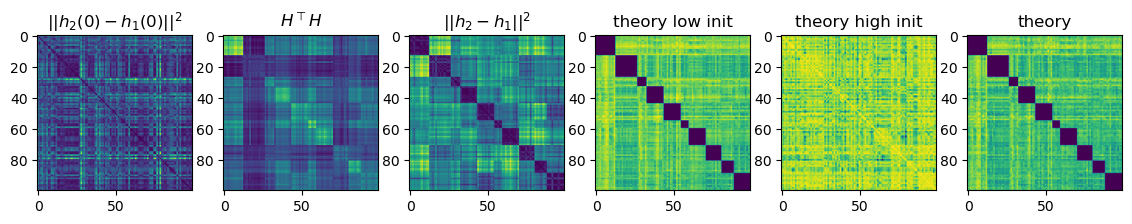

In [11]:
fig = plt.figure(figsize=(14, 14))
N = 6
plt.subplot(1, N, 1)
plt.title(r"$||h_2(0) - h_1(0)||^2$")
plt.imshow(dist2_h_0)
plt.subplot(1, N, 2)
plt.title(r"$H^\top H$")
plt.imshow(h @ h.T)
plt.subplot(1, N, 3)
plt.title(r"$||h_2 - h_1||^2$")
plt.imshow(dist2_h)
plt.subplot(1, N, 4)
plt.title(r"theory low init")
plt.imshow(A_low)
plt.subplot(1, N, 5)
plt.title(r"theory high init")
plt.imshow(A_high)
plt.subplot(1, N, 6)
plt.title(r"theory")
plt.imshow(theory)

In [22]:
import scipy

N = 400

labels = train_data.train_labels[:N]

X = train_data.train_data[np.argsort(labels)]
X = X.reshape(X.shape[0], -1)
D_x = scipy.spatial.distance_matrix(X, X)

labels = labels[np.argsort(labels)]
Y = torch.nn.functional.one_hot(labels)
D_y = scipy.spatial.distance_matrix(Y, Y)

A_low = D_x * D_y

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [23]:
from IPython.display import clear_output

H = np.random.random((len(A_low), 50))
# H = hid_act_0.to_numpy().copy()

# rate = 0.1
rate = 0.01 * lr


@njit
def update(H, rate):
    H_new = H.copy()
    for i in range(len(H)):
        for j in range(len(H)):
            H_new[i] = H_new[i] - (
                0.01
                * rate
                * (H[j] - H_new[i])
                * ((A_low**2)[i, j] - np.linalg.norm(H_new[i] - H[j]) ** 2)
            )
    return H_new


for n in trange(1000):
    H_last = H.copy()
    H = update(H, rate)

    if n % 1 == 0:
        clear_output(wait=True)

        dist2_theory = np.array(
            [[np.linalg.norm(h_1 - h_2) ** 2 for h_1 in H] for h_2 in H]
        )
        plt.imshow(dist2_theory)
        plt.show()

        # for label in range(10):
        #     plt.scatter(H[labels == label, 0], H[labels == label, 1], label=f"{label}")
        # plt.legend(loc="upper left")
        # plt.show()

    rate = lr / np.linalg.norm(H_last - H)

  0%|          | 0/1000 [00:00<?, ?it/s]

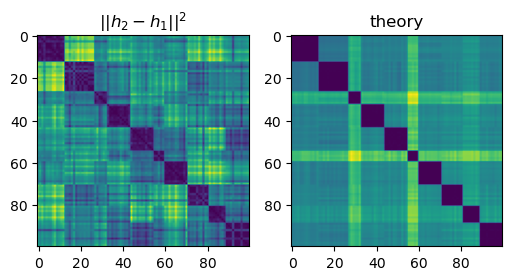

In [167]:
fig = plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.title(r"$||h_2 - h_1||^2$")
plt.imshow(dist2_h)

plt.subplot(1, 2, 2)
plt.title(r"theory")
plt.imshow(dist2_theory)

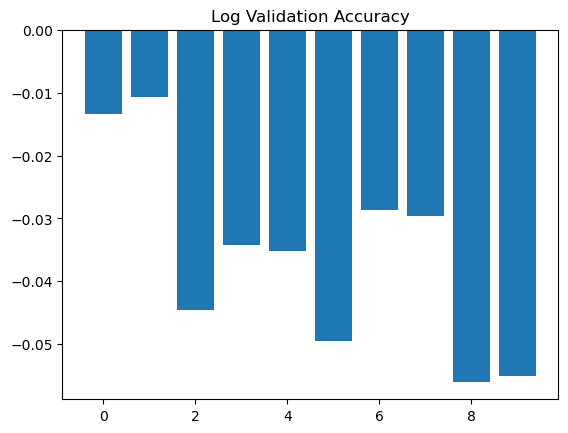

Validation Accuracy: 0.9655


In [15]:
## Evaluate
n_correct = np.zeros(10)
n_total = np.zeros(10)
for input, output in val_data:
    model_output = model(input)[0].detach().numpy()
    prediction = np.argmax(model_output)
    true = np.argmax(output)
    if prediction == true:
        n_correct[true] += 1
    n_total[true] += 1
plt.bar(np.arange(10), np.log(n_correct / n_total))
plt.title("Log Validation Accuracy")
plt.savefig(plot_path + f"log_val_acc_gain{gain}.png")
plt.show()
print(f"Validation Accuracy: {np.sum(n_correct)/np.sum(n_total)}")

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[ 0.070059    0.07229356 -0.09403867 -0.06663904 -0.0395126   0.1986508
 -0.0005967  -0.06067262  0.03754745  0.01652514]


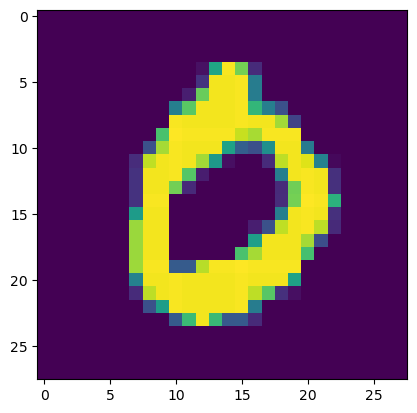

In [7]:
input, output = val_data[3]
print(output)
plt.imshow(input.cpu().reshape(28, 28))
print(model(input)[0].detach().numpy())

In [17]:
labels = np.array([np.argmax(output).item() for input, output in val_data])

for inputs, outputs in DataLoader(val_data, batch_size=len(val_data)):
    act = model(inputs)[1]
act = np.array([layer.detach().numpy() for layer in act])

In [18]:
@njit
def dist2(act1, act2):
    dist2 = []
    for layer in range(act1.shape[0]):
        if act1 is act2:
            n = len(act1[layer]) * len(act2[layer]) - 1
        else:
            n = len(act1[layer]) * len(act2[layer])
        distance = 0
        for point_1 in act1[layer]:
            for point_2 in act2[layer]:
                distance += np.linalg.norm(point_1 - point_2) / n
        dist2.append(distance)
    return np.array(dist2)

In [19]:
# baseline = np.array(dist2(act, act))

In [20]:
# for n in trange(10):
#     plt.plot(
#         dist2(act[:, labels == n], act[:, labels != n]) / baseline,
#         label=f"Distance^2 {n}",
#     )
# plt.legend(loc="lower right")
# plt.savefig(plot_path + f"rel_feature_gain{gain}.png")
# plt.show()

In [21]:
# for n in trange(10):
#     plt.plot(
#         dist2(act[:, labels == n], act[:, labels != n]),
#         label=f"Distance^2 {n}",
#     )
# plt.legend(loc="lower right")
# plt.savefig(plot_path + f"feature_gain{gain}.png")
# plt.show()